# Hutchinson Trace Estimation

This example illustrates the estimation the Hessian trace of a neural network using
Hutchinson's method
[[Hutchinson, 1990]](https://www.researchgate.net/publication/245083270_A_stochastic_estimator_of_the_trace_of_the_influence_matrix_for_Laplacian_smoothing_splines),
which is an algorithm to obtain such an an estimate from matrix-vector products:

\begin{align}\text{Let } A \in \mathbb{R}^{D \times D} \text{ and } v \in \mathbb{R}^D
    \text{ be a random vector such that } \mathbb{E}[vv^T] = I. \text{Then,}\end{align}

\begin{align}\mathrm{Tr}(A) = \mathbb{E}[v^TAv] = \frac{1}{V}\sum_{i=1}^{V}v_i^TAv_i.\end{align}

We will draw v from a Rademacher Distribution and use Hessian-free multiplication. This
can be done with plain autodiff, but note that there is no dependency between sampled
vectors, and the Hessian-vector product (HVP) could in principle be performed in
parallel. We can use BackPACK's :code:`HMP` (Hessian-matrix product) extension to do so,
and investigate the potential speedup.


Let's get the imports and define what a Rademacher distribution is



In [1]:
import time

import matplotlib.pyplot as plt
import torch

from backpack import backpack, extend
from backpack.extensions import HMP, DiagHessian
from backpack.hessianfree.hvp import hessian_vector_product
from backpack.utils.examples import load_one_batch_mnist

BATCH_SIZE = 256
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)


def rademacher(shape, dtype=torch.float32, device=DEVICE):
    """Sample from Rademacher distribution."""
    rand = ((torch.rand(shape) < 0.5)) * 2 - 1
    return rand.to(dtype).to(device)

## Creating the model and loss

We will use a small NN with 2 linear layers without bias (for a bias of size `d`, the
exact trace can be obtained in `d` HVPs).



In [2]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 20, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 10, bias=False),
).to(DEVICE)
model = extend(model)

loss_function = torch.nn.CrossEntropyLoss().to(DEVICE)
loss_function = extend(loss_function)

In the following, we load a batch from MNIST, compute the loss and trigger the
backward pass ``with(backpack(..))`` such that we have access to the extensions that
we are going to use (``DiagHessian`` and ``HMP)``).



In [3]:
x, y = load_one_batch_mnist(BATCH_SIZE)
x, y = x.to(DEVICE), y.to(DEVICE)


def forward_backward_with_backpack():
    """Provide working access to BackPACK's `DiagHessian` and `HMP`."""
    loss = loss_function(model(x), y)

    with backpack(DiagHessian(), HMP()):
        # keep graph for autodiff HVPs
        loss.backward(retain_graph=True)

    return loss


loss = forward_backward_with_backpack()

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.37MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.52MB/s]


## Exact trace computation
To make sure our implementation is fine, and to develop a feeling for the Hutchinson
estimator quality, let's compute the exact trace by summing up the Hessian diagonal.



In [4]:
def exact_trace():
    """Exact trace from sum of Hessian diagonal."""
    param_trace = [p.diag_h.sum().item() for p in model.parameters()]
    return sum(param_trace)


print("Exact trace: {:.3f}".format(exact_trace()))

Exact trace: 12.455


## Trace estimation (BackPACK's :code:`HMP`)
BackPACK's :code:`HMP` extension gives access to multiplication with the parameter
Hessian, which is one diagonal block in the full Hessian whose trace we want to
estimate. The multiplication can even handle multiple vectors at a time. Here is the
implementation. The computation of :code:`V` HVPs, which might exceed our available
memory, is chunked into batches of size :code:`V_batch`.



In [5]:
def hutchinson_trace_hmp(V, V_batch=1):
    """Hessian trace estimate using BackPACK's HMP extension.

    Perform `V_batch` Hessian multiplications at a time.
    """
    V_count = 0
    trace = 0

    while V_count < V:
        V_missing = V - V_count
        V_next = min(V_batch, V_missing)

        for param in model.parameters():
            v = rademacher((V_next, *param.shape))
            Hv = param.hmp(v).detach()
            vHv = torch.einsum("i,i->", v.flatten(), Hv.flatten().detach())
            trace += vHv / V

        V_count += V_next

    return trace


print(
    "Trace estimate via BackPACK's HMP extension: {:.3f}".format(
        hutchinson_trace_hmp(V=1000, V_batch=10)
    )
)

Trace estimate via BackPACK's HMP extension: 12.308


## Trace estimation (autodiff, full Hessian)
We can also use autodiff tricks to compute a single HVP at a time, provided by utility
function :code:`hessian_vector_product` in BackPACK. Here is the implementation, and a
test:



In [6]:
def hutchinson_trace_autodiff(V):
    """Hessian trace estimate using autodiff HVPs."""
    trace = 0

    for _ in range(V):
        vec = [rademacher(p.shape) for p in model.parameters()]
        Hvec = hessian_vector_product(loss, list(model.parameters()), vec)

        for v, Hv in zip(vec, Hvec):
            vHv = torch.einsum("i,i->", v.flatten(), Hv.flatten())
            trace += vHv / V

    return trace


print(
    "Trace estimate via PyTorch's HVP: {:.3f}".format(hutchinson_trace_autodiff(V=1000))
)

Trace estimate via PyTorch's HVP: 12.142


## Trace estimation (autodiff, block-diagonal Hessian)
Since :code:`HMP` uses only the Hessian block-diagonal and not the full Hessian, here
is the corresponding autodiff implementation using the same matrix as :code:`HMP`. We
are going to reinvestigate it for benchmarking.



In [7]:
def hutchinson_trace_autodiff_blockwise(V):
    """Hessian trace estimate using autodiff block HVPs."""
    trace = 0

    for _ in range(V):
        for p in model.parameters():
            v = [rademacher(p.shape)]
            Hv = hessian_vector_product(loss, [p], v)
            vHv = torch.einsum("i,i->", v[0].flatten(), Hv[0].flatten())

            trace += vHv / V

    return trace


print(
    "Trace estimate via PyTorch's blockwise HVP: {:.3f}".format(
        hutchinson_trace_autodiff_blockwise(V=1000)
    )
)

# restore BackPACK IO, which is deleted by autodiff HVP
loss = forward_backward_with_backpack()

Trace estimate via PyTorch's blockwise HVP: 12.581


## Trace approximation accuracy
Next, let's observe how the approximation improves with the number of samples. Here,
we plot multiple runs of the Hutchinson trace estimate, initialized at different
random seeds.



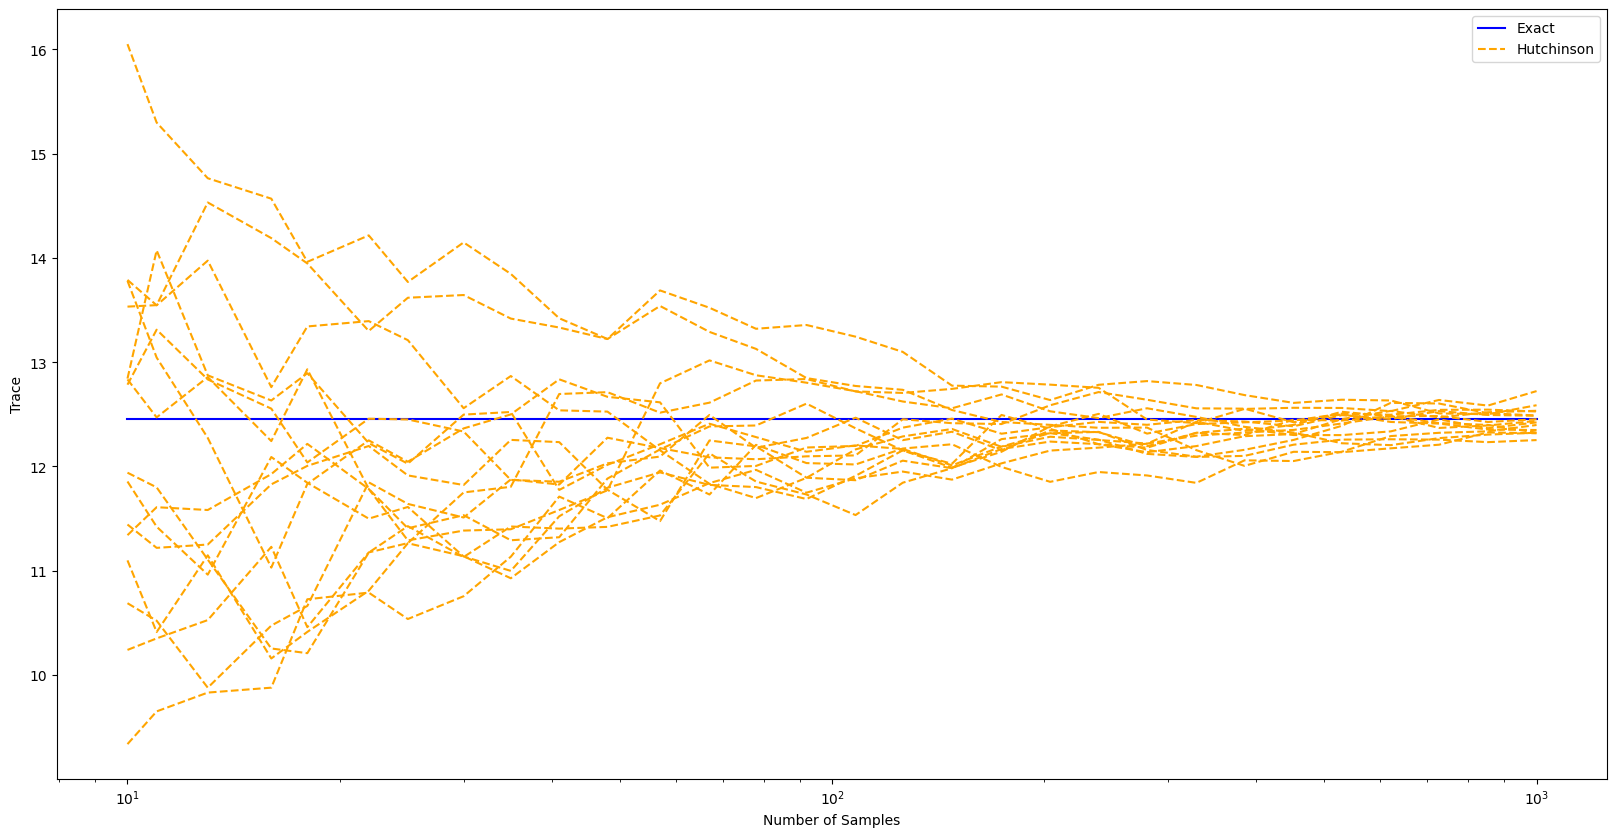

In [8]:
V_steps = 30
V_list = torch.logspace(1, 3, steps=V_steps).int()
V_batch = 10
num_curves = 15

fig = plt.figure(figsize=(20, 10))
plt.xlabel("Number of Samples")
plt.ylabel("Trace")
plt.semilogx(V_list, V_steps * [exact_trace()], color="blue", label="Exact")


for i in range(num_curves):
    trace_estimates = []

    for V in V_list:
        torch.manual_seed(i)
        trace_estimates.append(hutchinson_trace_hmp(V, V_batch))

    plt.semilogx(
        V_list,
        [trace_estimate.cpu() for trace_estimate in trace_estimates],
        linestyle="--",
        color="orange",
        label="Hutchinson" if i == 0 else None,
    )

_ = plt.legend()

## Runtime comparison
Finally, we investigate if the trace estimation is sped up by vectorizing the HVPs.
In particular, let's compare the estimations using autodiff HVPs (no parallelization),
autodiff block-diagonal HVPs (no parallelization) and block-diagonal vectorized HVPs
(:code:`HMP`).



In [ ]:
V = 1000


def time_hutchinson_trace_autodiff(V):
    start = time.time()
    trace = hutchinson_trace_autodiff(V)
    end = time.time()
    duration = end - start
    print(
        "Estim. trace: {:.3f}, time {:.3f}, (autodiff, full HVP)".format(
            trace, duration
        )
    )


def time_hutchinson_trace_autodiff_blockwise(V):
    start = time.time()
    trace = hutchinson_trace_autodiff_blockwise(V)
    end = time.time()
    duration = end - start
    print(
        "Estim. trace: {:.3f}, time {:.3f}, (autodiff, block HVP)".format(
            trace, duration
        )
    )


def time_hutchinson_trace_hmp(V, V_batch):
    start = time.time()
    trace = hutchinson_trace_hmp(V, V_batch)
    end = time.time()
    duration = end - start
    print(
        "Estim. trace: {:.3f}, time {:.3f}, (BackPACK, V_batch={} block HVP)".format(
            trace, duration, V_batch
        )
    )


print("Exact trace:  {:.3f}".format(exact_trace()))
time_hutchinson_trace_autodiff(V)
time_hutchinson_trace_autodiff_blockwise(V)
# restore BackPACK IO, which is deleted by autodiff HVP
loss = forward_backward_with_backpack()
time_hutchinson_trace_hmp(V, V_batch=5)
time_hutchinson_trace_hmp(V, V_batch=10)
time_hutchinson_trace_hmp(V, V_batch=20)

Exact trace:  12.455
Estim. trace: 12.373, time 1.424, (autodiff, full HVP)
Estim. trace: 12.095, time 1.657, (autodiff, block HVP)
Estim. trace: 12.465, time 0.288, (BackPACK, V_batch=5 block HVP)
Estim. trace: 12.298, time 0.255, (BackPACK, V_batch=10 block HVP)
Estim. trace: 12.345, time 0.111, (BackPACK, V_batch=20 block HVP)


: 

Looks like the parallel Hessian-vector products are able to speed up the
computation. Nice.



Note that instead of the Hessian, we could have also used other interesting matrices,
such as the generalized Gauss-Newton. BackPACK also offers a vectorized multiplication
with the latter's block-diagonal (see the :code:`GGNMP` extension).

